# Прогноз количества заказов такси на следующий час

Компания собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.

Значение метрики *RMSE* на тестовой выборке размером 10% от исходных данных должно быть не больше 48.

Структура исходных данных:
- datetime - время заказа такси
- num_orders - количество заказов

## 1. Подготовка

In [1]:
#Импорт необходимых библиотек:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor, Pool

In [2]:
#Загрузка данных:
taxi_data = pd.read_csv('/datasets/taxi.csv')

In [3]:
#Общая информация:
taxi_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
datetime      26496 non-null object
num_orders    26496 non-null int64
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [4]:
#Несколько строк таблицы:
taxi_data

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
...,...,...
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39


В предоставленных данных только два столбца: Дата-время и количество заказов такси. Пропусков нет, и, похоже, записи уже расположены в хронологическом порядке (но на всякий случай можно это проверить). "Замеры" проводились каждые 10 минут.

Данные требуется подготовить:
- Перевести столбец datetime из типа object в datetime
- Сделать столбец datetime индексами записей
- Упорядочить получившийся список по дате
- Ресемплировать записи по одному часу

In [5]:
#Создание временного ряда из сырых данных:
taxi_data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

#Сортировка по дате и времени:
taxi_data.sort_index(inplace=True)

#Ресемплирование по 1 часу:
taxi_data = taxi_data.resample('1H').sum()
taxi_data

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


Ряд содержит данные о заказах такси за каждый час в течение 6 месяцев. Перейдем к анализу.

## 2. Анализ

Рассмотрю зависимость количества заказов такси от календарных и временных признаков: часа, дня недели и месяца. Для этого построю простые гистограммы и поищу закономерности.

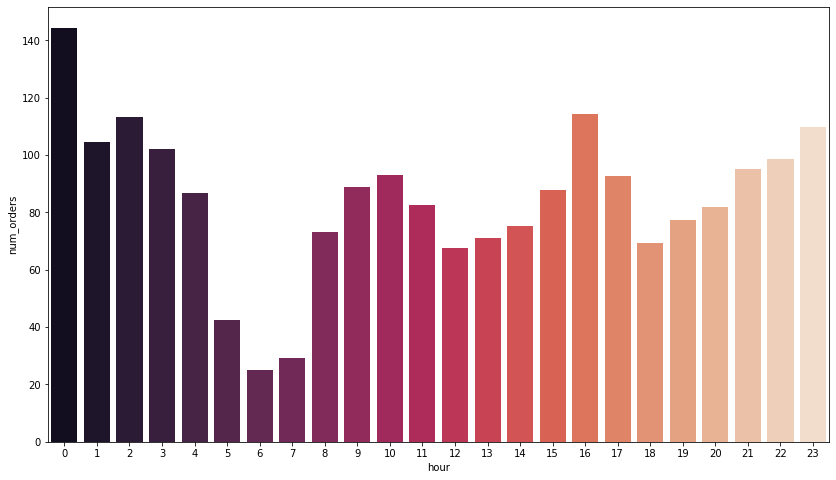

In [6]:
#Добавление дополнительного признака - часа, в который заказывается такси:
taxi_data['hour'] = taxi_data.index.hour

#Создание сводной таблицы, в которой по часам вычислены средние значения количества заказов:
orders_by_hour = taxi_data.pivot_table(taxi_data, index='hour', aggfunc=np.mean)

#Построение гистограммы по сводной таблице:
fig, ax = plt.subplots(figsize=(14, 8))
sns.barplot(x=orders_by_hour.index, y=orders_by_hour['num_orders'], palette="rocket")

Можно заметить, что количество заказов значительно меняется в течение дня: В 0 часов - пик спроса на такси, а в 6-7 утра - сильная просадка. Небольшие просадки наблюдаются около 12 и 18 часов, а вторичные пики - около 10 и 16. Зависимость количества заказов от времени дня не прямая, значит этот признак нужно задавать, как категориальный.

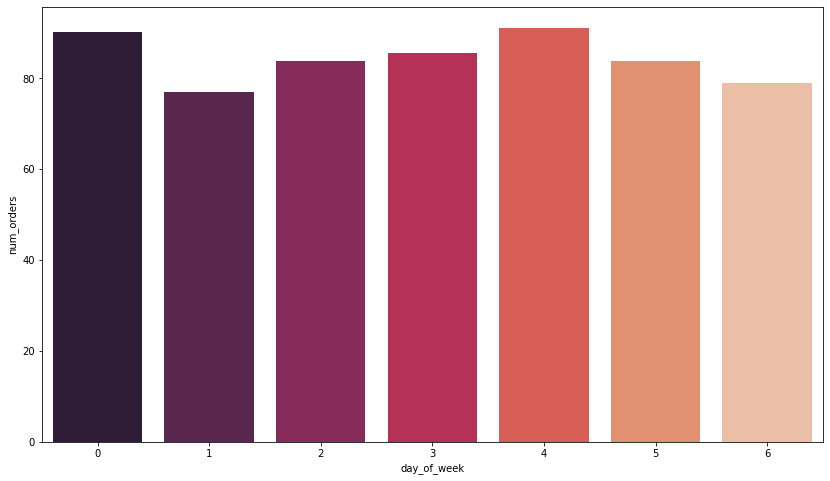

In [7]:
#Добавление дополнительного признака - дня недели, в который заказывается такси:
taxi_data['day_of_week'] = taxi_data.index.dayofweek

#Создание сводной таблицы, в которой по дням недели вычислены средние значения количества заказов:
orders_by_day_of_week = taxi_data.pivot_table(taxi_data, index='day_of_week', aggfunc=np.mean)

#График:
fig, ax = plt.subplots(figsize=(14, 8))
sns.barplot(x=orders_by_day_of_week.index, y=orders_by_day_of_week['num_orders'], palette="rocket")

Спрос на такси от дня недели зависит гораздо меньше, чем от времени дня, но зависимость всё же прослеживается: понедельник и пятница - самые загруженные дни, вторник и воскресенье - относительно свободные. Этот признак также категориальный.

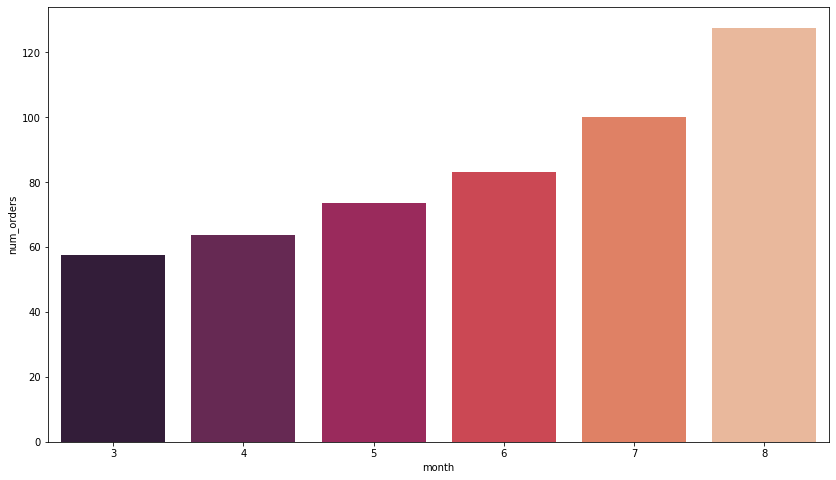

In [8]:
#Дополнительный признак - месяц:
taxi_data['month'] = taxi_data.index.month

#Сводная таблица:
orders_by_month = taxi_data.pivot_table(taxi_data, index='month', aggfunc=np.mean)

#График:
fig, ax = plt.subplots(figsize=(14, 8))
sns.barplot(x=orders_by_month.index, y=orders_by_month['num_orders'], palette="rocket")

Видно, что спрос на такси в марте-августе неуклонно (и даже с ускорением) растет. Этот дополнительный признак можно рассматривать, как количественный.

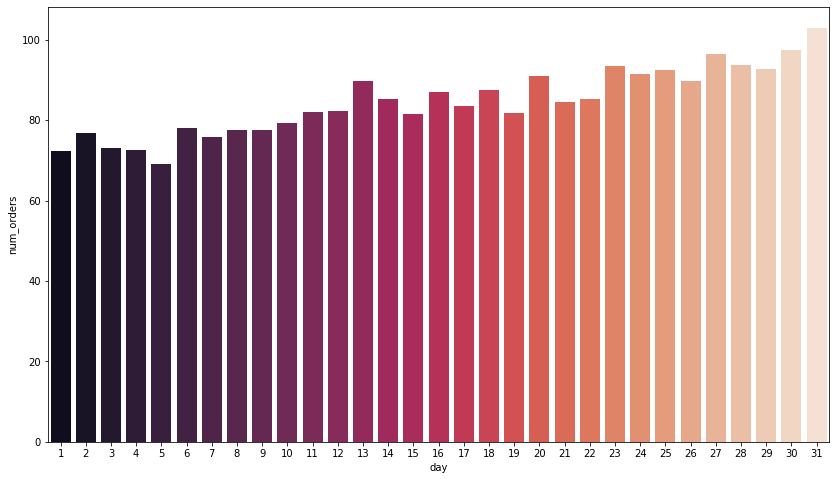

In [9]:
#Новый признак - день месяца:
taxi_data['day'] = taxi_data.index.day

#Сводная таблица:
orders_by_day = taxi_data.pivot_table(taxi_data, index='day', aggfunc=np.mean)

#График:
fig, ax = plt.subplots(figsize=(14, 8))
sns.barplot(x=orders_by_day.index, y=orders_by_day['num_orders'], palette="rocket")

В зависимости от дня месяца количество заказов растет от начала месяца к концу с некоторыми колебаниями. Этот признак тоже можно рассматривать, как количественный. На гистограмме представлены средние значения заказов по дню за все месяцы, можно дополнительно построить линейный график за всё время:

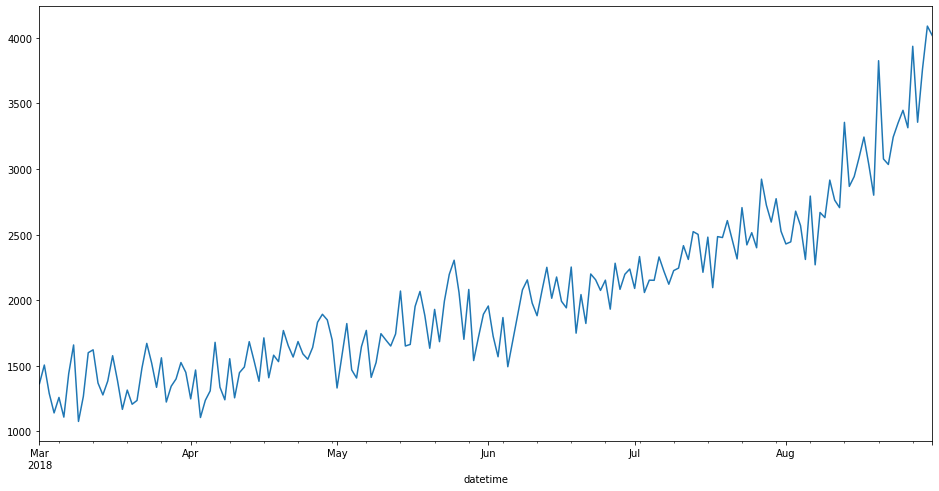

In [10]:
#Ресемплирование данных по одному дню, суммирование заказов за день и построение простого графика:
fig, ax = plt.subplots(figsize=(16, 8))
taxi_data['num_orders'].resample('1D').sum().plot()

По графику видно, что, действительно, общий тренд - увеличение количества заказов с начала марта до конца августа.

Теперь для каждого объекта добавлю "отстающие значения" - количество заказов в предыдущий день, два дня назад и т. д. Ограничусь отрезком в 2 недели. И несколько значений скользящего среднего с разным размером окна. Затем изучу скоррелированность новых признаков с целевым и возможно уберу некоторые признаки.

In [11]:
#Добавление в таблицу "отстающих значений" (максимум - на две недели):
for lag in range(1, 15):
    taxi_data['lag_{}'.format(lag)] = taxi_data['num_orders'].shift(lag)

In [12]:
#Добавление скользящих средних:
for window in [3, 5, 7, 10, 14, 20, 25, 30, 45, 60]:
    taxi_data['rolling_mean_{}'.format(window)] = taxi_data['num_orders'].shift().rolling(window).mean()

In [13]:
#Коэффициенты корреляции между целевым признаком и прочими признаками:
taxi_data.corr()['num_orders'].tail(60)

num_orders         1.000000
hour               0.004292
day_of_week       -0.019628
month              0.510108
day                0.165312
lag_1              0.624138
lag_2              0.465444
lag_3              0.321173
lag_4              0.248791
lag_5              0.230489
lag_6              0.238449
lag_7              0.291733
lag_8              0.310036
lag_9              0.270676
lag_10             0.263643
lag_11             0.317913
lag_12             0.332466
lag_13             0.313831
lag_14             0.259667
rolling_mean_3     0.556788
rolling_mean_5     0.495734
rolling_mean_7     0.488784
rolling_mean_10    0.493754
rolling_mean_14    0.510035
rolling_mean_20    0.490381
rolling_mean_25    0.569528
rolling_mean_30    0.547438
rolling_mean_45    0.519054
rolling_mean_60    0.550833
Name: num_orders, dtype: float64

По коэффициентам корреляции видно, что новые признаки связаны с целевым признаком. Коэффициенты около нуля у признаков hour и day_of_week подтверждают, что к этим признакам нужно относиться, как к категориальным. Скользящее среднее с окном в 25 дней лучше всего скоррелировано с количеством заказов, оставлю этот признак, а остальные столбцы со скользящим средним удалю.

In [14]:
#Создание списка названий столбцов для удаления:
columns_to_del = []
windows_to_del = [3, 5, 7, 10, 14, 20, 30, 45, 60]

for i in range(len(windows_to_del)):
    columns_to_del.append('rolling_mean_'+str(windows_to_del[i]))

#Удаление лишних столбцов:
taxi_data = taxi_data.drop(columns_to_del, axis=1)
taxi_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 20 columns):
num_orders         4416 non-null int64
hour               4416 non-null int64
day_of_week        4416 non-null int64
month              4416 non-null int64
day                4416 non-null int64
lag_1              4415 non-null float64
lag_2              4414 non-null float64
lag_3              4413 non-null float64
lag_4              4412 non-null float64
lag_5              4411 non-null float64
lag_6              4410 non-null float64
lag_7              4409 non-null float64
lag_8              4408 non-null float64
lag_9              4407 non-null float64
lag_10             4406 non-null float64
lag_11             4405 non-null float64
lag_12             4404 non-null float64
lag_13             4403 non-null float64
lag_14             4402 non-null float64
rolling_mean_25    4391 non-null float64
dtypes: float64(15), int64(5)
memory us

В начале таблицы образовалось небольшое количество пропущенных значений, которые могут помешать дальнейшей обработке данных и обучению моделей. Заполняя пропуски можно ошибиться и создать утечку целевого признака. Пропусков не очень много, и если строки с ними просто удалить, то потеряются данные всего за одни сутки - 1 марта. По этим причинам строки с пропусками я удалю.

In [15]:
#Удаление строк с пропусками:
taxi_data = taxi_data.dropna()

Разделю данные на обучающую, валидационную и тестовую выборки. По условию тестовая должна содержать 10% записей. Такое же количество выделю под валидационную. Перемешивать исходную выборку при разделении нельзя, чтобы предотвратить утечку целевого признака.

In [16]:
#Создание обучающей и тестовой выборок:
taxi_train, taxi_test = train_test_split(taxi_data, shuffle=False, test_size=0.1)

#Выделение валидационной выборки из обучающей:
taxi_train, taxi_valid = train_test_split(taxi_train, shuffle=False, test_size=1/9)

#Разбивка выборок на признаки и целевой признак:
features_train = taxi_train.drop(['num_orders'], axis=1)
target_train = taxi_train['num_orders']

features_valid = taxi_valid.drop(['num_orders'], axis=1)
target_valid = taxi_valid['num_orders']

features_test = taxi_test.drop(['num_orders'], axis=1)
target_test = taxi_test['num_orders']

Осталось стандартизировать количественные признаки и подготовить категориальные. Попробую обучить на данных модели "случайного леса" и одну из моделей градиентного бустинга (lgbm или catboost). Для "случайного леса" категориальные признаки нужно преобразавать методом OHE, а для популярных библиотек градиентного бустинга в этом необходимости нет, поэтому я подготовлю два набора данных - для каждой модели свой.

In [17]:
#Стандартизация количественных признаков:
scaler = StandardScaler()

columns_for_std = list(features_train.columns[2:])

scaler.fit(features_train[columns_for_std])

features_train[columns_for_std] = (
    pd.DataFrame(scaler.transform(features_train[columns_for_std]), index=features_train.index))
                 
features_valid[columns_for_std] = (
    pd.DataFrame(scaler.transform(features_valid[columns_for_std]), index=features_valid.index))
                 
features_test[columns_for_std] = (
    pd.DataFrame(scaler.transform(features_test[columns_for_std]), index=features_test.index))

In [18]:
#Выборки для обучения и проверки моделей RandomForestRegressor:
features_ohe_train = features_train
features_ohe_valid = features_valid
features_ohe_test = features_test

features_ohe_train = features_ohe_train.drop(['hour', 'day_of_week'], axis=1)
features_ohe_valid = features_ohe_valid.drop(['hour', 'day_of_week'], axis=1)
features_ohe_test = features_ohe_test.drop(['hour', 'day_of_week'], axis=1)

In [19]:
#Кодирование категориальных признаков в выборках методом OHE:
features_ohe_train = (
    features_ohe_train
    .join(pd.get_dummies(features_train['hour'], drop_first=True, prefix='hour'))
    .join(pd.get_dummies(features_train['day_of_week'], drop_first=True, prefix='day_of_week'))
)

features_ohe_valid = (
    features_ohe_valid
    .join(pd.get_dummies(features_valid['hour'], drop_first=True, prefix='hour'))
    .join(pd.get_dummies(features_valid['day_of_week'], drop_first=True, prefix='day_of_week'))
)

features_ohe_test = (
    features_ohe_test
    .join(pd.get_dummies(features_test['hour'], drop_first=True, prefix='hour'))
    .join(pd.get_dummies(features_test['day_of_week'], drop_first=True, prefix='day_of_week'))
)

Выборки признаков features_train, features_valid и features_test буду использовать для обучения и проверки моделей градиентного бустинга, а features_ohe_train, features_ohe_valid и features_ohe_test - RandomForestRegressor. Выборки с целевым признаком будут общими для всех моделей. Можно приступить к обучению.

## 3. Обучение

In [20]:
#Обучение, проверка и подбор лучших параметров модели RandomForestRegressor:

#Словарь с названиями гиперпараметров и их значениями для тюнинга модели:
forest_params = {'n_estimators': range(10, 111, 20),
                 'max_depth': range(3, 19, 3),
                 'min_samples_leaf': range(3, 19, 3)
                }

#Создание совокупностей параметров из словаря:
forest_grid = ParameterGrid(forest_params)

min_rmse = 1000
best_params = {}

#Обучение и поиск самой качественной модели случайного леса:
for params in forest_grid:
    
    print(params)
    
    model = RandomForestRegressor(random_state=1000, **params)
    model.fit(features_ohe_train, target_train)
    predictions = model.predict(features_ohe_valid)

    rmse = mean_squared_error(target_valid, predictions)**0.5
    if rmse < min_rmse:
        min_rmse = rmse
        best_params = params
        
    print('rmse:', rmse)
    print()

{'max_depth': 3, 'min_samples_leaf': 3, 'n_estimators': 10}
rmse: 44.05993025237987

{'max_depth': 3, 'min_samples_leaf': 3, 'n_estimators': 30}
rmse: 44.20255645333322

{'max_depth': 3, 'min_samples_leaf': 3, 'n_estimators': 50}
rmse: 44.10600540710448

{'max_depth': 3, 'min_samples_leaf': 3, 'n_estimators': 70}
rmse: 44.099383093348976

{'max_depth': 3, 'min_samples_leaf': 3, 'n_estimators': 90}
rmse: 44.06746874167881

{'max_depth': 3, 'min_samples_leaf': 3, 'n_estimators': 110}
rmse: 44.0167984919146

{'max_depth': 3, 'min_samples_leaf': 6, 'n_estimators': 10}
rmse: 44.06098558406384

{'max_depth': 3, 'min_samples_leaf': 6, 'n_estimators': 30}
rmse: 44.20160698354085

{'max_depth': 3, 'min_samples_leaf': 6, 'n_estimators': 50}
rmse: 44.10527803803807

{'max_depth': 3, 'min_samples_leaf': 6, 'n_estimators': 70}
rmse: 44.09883847007193

{'max_depth': 3, 'min_samples_leaf': 6, 'n_estimators': 90}
rmse: 44.06749415642412

{'max_depth': 3, 'min_samples_leaf': 6, 'n_estimators': 110}
rms

In [21]:
#Лучшая метрика rmse с гиперпараметрами, при которых она была достигнута:
print('Лучшая rmse:', min_rmse, '\n')
print('Гиперпараметры лучшей модели:\n', best_params)

Лучшая rmse: 33.4464401738574 

Гиперпараметры лучшей модели:
 {'max_depth': 18, 'min_samples_leaf': 3, 'n_estimators': 70}


Теперь обучу модели грандиентного бустинга (библиотека catboost) с разными гиперпараметрами, а затем сравню качество лучшей модели RandomForestRegressor с лучшей моделью catboost.

In [22]:
categorial = ['hour', 'day_of_week'] #список категориальных признаков

#Подготовленная обучающая выборка в формате catboost'а:
train_pool = Pool(features_train,
                  label=target_train,
                  cat_features=categorial
                  )

#Подготовленная валидационная выборка в формате catboost'а:
valid_pool = Pool(features_valid,
                  label=target_valid,
                  cat_features=categorial
                  )

In [23]:
#Словарь с названиями гиперпараметров и их значениями для тюнинга модели:
cat_params = {'loss_function': ['RMSE'],
              'cat_features': [categorial],
              'random_seed': [1000],
              'verbose': [100],
              'early_stopping_rounds': [100],
              'iterations': [1000],
              'learning_rate': [0.005, 0.01, 0.05, 0.1],
              'depth': [4, 6, 8]
             }

#Создание совокупностей параметров из словаря:
cat_grid = ParameterGrid(cat_params)

min_rmse_cat = 1000
best_params_cat = {}

#Обучение и поиск лучших гиперпараметров модели catboost:
for params in cat_grid:
    
    print(params)
    
    cat_model = CatBoostRegressor(**params)

    cat_model.fit(train_pool, eval_set=valid_pool)
    
    if cat_model.get_best_score()['validation']['RMSE'] < min_rmse_cat:
        min_rmse_cat = cat_model.get_best_score()['validation']['RMSE']
        best_params_cat = params

{'cat_features': ['hour', 'day_of_week'], 'depth': 4, 'early_stopping_rounds': 100, 'iterations': 1000, 'learning_rate': 0.005, 'loss_function': 'RMSE', 'random_seed': 1000, 'verbose': 100}
0:	learn: 35.6664960	test: 58.3534087	best: 58.3534087 (0)	total: 50.5ms	remaining: 50.5s
100:	learn: 29.7420903	test: 50.6754882	best: 50.6754882 (100)	total: 2.17s	remaining: 19.3s
200:	learn: 26.5440737	test: 45.8488633	best: 45.8488633 (200)	total: 4.3s	remaining: 17.1s
300:	learn: 24.8154758	test: 42.5947596	best: 42.5947596 (300)	total: 6.36s	remaining: 14.8s
400:	learn: 23.8197681	test: 40.1790701	best: 40.1790701 (400)	total: 8.99s	remaining: 13.4s
500:	learn: 23.1489581	test: 38.4311423	best: 38.4311423 (500)	total: 11s	remaining: 11s
600:	learn: 22.6788133	test: 37.0396814	best: 37.0396814 (600)	total: 13.1s	remaining: 8.69s
700:	learn: 22.3546038	test: 36.0144459	best: 36.0144459 (700)	total: 15.2s	remaining: 6.5s
800:	learn: 22.1214680	test: 35.2727892	best: 35.2727892 (800)	total: 17.4s

In [24]:
#Лучшая метрика rmse с гиперпараметрами, при которых она была достигнута (модель catboost):
print('Лучшая rmse:', min_rmse_cat, '\n')
print('Гиперпараметры лучшей модели:\n', best_params_cat)

Лучшая rmse: 30.831224477395146 

Гиперпараметры лучшей модели:
 {'cat_features': ['hour', 'day_of_week'], 'depth': 8, 'early_stopping_rounds': 100, 'iterations': 1000, 'learning_rate': 0.05, 'loss_function': 'RMSE', 'random_seed': 1000, 'verbose': 100}


Были найдены оптимальные гиперпараметры для модели "случайного леса" sklearn и градиентного бустинга catboost. Бустинг показал несколько лучшие результаты: rmse меньше примерно на 2.6. Стоит проверить модели на адекватность - сравнить их предсказания с предсказаниями по простой стратегии, а затем окончательно проверить качество на тестовой выборке.

## 4. Тестирование

Для проверки обеих моделей на адекватность вычислю метрику rmse для предсказаний по простым стратегиям:
1. Все предсказания количества заказов в тестовой выборке будут равны медиане обучающей + валидационной выборки
2. Предсказания равняются среднему значению заказов обучающей + валидационной выборки
3. Каждое последующее значение прогнозируется предыдущим

In [25]:
#Объединение обучающей и валидационной выборок с целевым признаком:
new_target_train = taxi_data['num_orders']
new_target_train = new_target_train['2018-03-02 01:00:00':'2018-08-13 15:00:00']

In [26]:
#Предсказания по первой простой стратегии (медиана):
dummy1_predictions = pd.Series(new_target_train.median(), index=target_test.index)

#Предсказания по второй простой стратегии (среднее):
dummy2_predictions = pd.Series(new_target_train.mean(), index=target_test.index)

#Предсказания по третьей простой стратегии (предыдущее):
dummy3_predictions = target_test.shift()
dummy3_predictions[0] = new_target_train[-1]

In [27]:
#Вычисление rmse для каждой простой стратегии:
print('Предсказания медианой, rmse:\t', mean_squared_error(target_test, dummy1_predictions)**0.5, '\n')

print('Предсказания средним, rmse:\t', mean_squared_error(target_test, dummy2_predictions)**0.5, '\n')

print('Предсказания предыдущим, rmse:\t', mean_squared_error(target_test, dummy3_predictions)**0.5, '\n')

Предсказания медианой, rmse:	 87.21093811714634 

Предсказания средним, rmse:	 84.68979207380566 

Предсказания предыдущим, rmse:	 58.881776776551476 



Лучшее rmse простой стратегии (предыдущее значение) - 58.88, если модель покажет метрику ниже этой, то она адекватна. Впрочем, порог метрики задан в техзадании - 48, поэтому любая модель, подходящая под этот критерий уже будет адекватна.

Проверю лучшие модели на тестовой выборке.

In [28]:
#Лучшая модель RandomForestRegressor:
best_forest_model = RandomForestRegressor(random_state=1000, **best_params)
best_forest_model.fit(features_ohe_train, target_train)

#Лучшая модель catboost:
best_cat_model = CatBoostRegressor(**best_params_cat)
best_cat_model.fit(train_pool, eval_set=valid_pool)

0:	learn: 34.8932233	test: 57.3388871	best: 57.3388871 (0)	total: 7.83ms	remaining: 7.83s
100:	learn: 19.2368541	test: 32.9681959	best: 32.9681959 (100)	total: 6.05s	remaining: 53.9s
200:	learn: 16.9518828	test: 31.4217774	best: 31.4217774 (200)	total: 12.3s	remaining: 48.8s
300:	learn: 15.1101814	test: 31.0996693	best: 31.0728465 (294)	total: 18.8s	remaining: 43.7s
400:	learn: 13.6759852	test: 31.0533168	best: 31.0325042 (357)	total: 25.3s	remaining: 37.8s
500:	learn: 12.5017464	test: 30.9539858	best: 30.9508137 (498)	total: 31.9s	remaining: 31.8s
600:	learn: 11.4584092	test: 30.9668641	best: 30.9362498 (552)	total: 38.7s	remaining: 25.7s
700:	learn: 10.5346392	test: 30.8748983	best: 30.8312245 (662)	total: 45.3s	remaining: 19.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 30.83122448
bestIteration = 662

Shrink model to first 663 iterations.


In [29]:
#Предсказания и вычисление rmse для лучших моделей:

forest_predictions = best_forest_model.predict(features_ohe_test)
print('rmse на тестовой выборке, модель RandomForestRegressor:', mean_squared_error(target_test, forest_predictions)**0.5, '\n')

cat_predictions = best_cat_model.predict(features_test)
print('rmse на тестовой выборке, модель catboost:', mean_squared_error(target_test, cat_predictions)**0.5)

rmse на тестовой выборке, модель RandomForestRegressor: 52.10882394495797 

rmse на тестовой выборке, модель catboost: 50.97039912707395


Модели на тестовой выборке показали недостаточное качество предсказаний. Мне кажется, это произошло из-за того, что в обучении моделей для финального тестирования участвовала только обучающая выборка, между ней и тестовой еще 18 дней (они были использованы в валидационной выборке). При анализе полной выборки я выяснил, что количество заказов растет в августе гораздо быстрее, чем в прошлые месяцы, а финальные модели при обучении совсем не захватили этот период. Попробую обучить модели с теми же гиперпараметрами, но на объединенной обучающей и валидационной выборке.

In [30]:
#Создание новой обучающей выборки - соединение прошлой обучающей и валидационной:
new_features_ohe_train = pd.concat([features_ohe_train, features_ohe_valid])
new_target_train = pd.concat([target_train, target_valid])

In [31]:
#Обучение и проверка модели RandomForestRegressor:
testing_params = {'max_depth': 18, 'min_samples_leaf': 3, 'n_estimators': 70}

testing_forest_model = RandomForestRegressor(random_state=1000, **testing_params)
testing_forest_model.fit(new_features_ohe_train, new_target_train)

testing_forest_predictions = testing_forest_model.predict(features_ohe_test)

print('rmse testing RandomForestRegressor:', mean_squared_error(target_test, testing_forest_predictions)**0.5)

rmse testing RandomForestRegressor: 42.81311435081569


Метрика гораздо меньше пороговой. Модель RandomForestRegressor прошла финальное тестирование успешно.

In [32]:
#Новая обучающая выборка для catboost:
new_features_train = pd.concat([features_train, features_valid])

new_train_pool = Pool(new_features_train,
                      label=new_target_train,
                      cat_features=categorial
                      )

testing_cat_params = {'cat_features': ['hour', 'day_of_week'],
                      'depth': 8,
                      'early_stopping_rounds': 100,
                      'iterations': 1000,
                      'learning_rate': 0.05,
                      'loss_function': 'RMSE',
                      'random_seed': 1000,
                      'verbose': 100
                     }

In [33]:
#Обучение и тестирование:
testing_cat_model = CatBoostRegressor(**testing_cat_params)
testing_cat_model.fit(new_train_pool)
testing_cat_predictions = testing_cat_model.predict(features_test)
print('\nrmse на тестовой выборке, модель catboost:', mean_squared_error(target_test, testing_cat_predictions)**0.5)

0:	learn: 37.7139841	total: 7.87ms	remaining: 7.87s
100:	learn: 20.9340213	total: 5.8s	remaining: 51.6s
200:	learn: 18.7091366	total: 11.7s	remaining: 46.7s
300:	learn: 16.6325582	total: 18.3s	remaining: 42.5s
400:	learn: 15.0749952	total: 24.8s	remaining: 37.1s
500:	learn: 13.7428168	total: 31.5s	remaining: 31.3s
600:	learn: 12.5630813	total: 38s	remaining: 25.2s
700:	learn: 11.4662035	total: 44.6s	remaining: 19s
800:	learn: 10.5161709	total: 51.2s	remaining: 12.7s
900:	learn: 9.6986190	total: 57.8s	remaining: 6.35s
999:	learn: 8.9916987	total: 1m 4s	remaining: 0us

rmse на тестовой выборке, модель catboost: 40.046667518171475


Модель catboost на тестовой выборке также показала метрику ниже порога, заданного заказчиком.

## Вывод

В ходе выполнения проекта я изучил данные по заказам такси и нашел в них определенные закономерности. Выделил признаки, разбил их на категориальные и количественные, подготовил для обучения разных моделей. Далее я подобрал оптимальные гиперпараметры для модели RandomForestRegressor библиотеки sklearn и CatBoostRegressor из библиотеки catboost. Пороговая метрика rmse для тестовой выборке была установлена заказчиком на значении 48 - ее преодолели обе модели.

RandomForestRegressor обучается быстрее, но показывает худшее rmse, чем catboost - примерно на 2.8

Заказчику можно представить полученные результаты и уточнить что для решения задачи будет важнее: скорость работы или точность предсказаний.

Стоит отметить, что со временем любую из этих моделей потребуется переобучить, включив новые данные в обучающую выборку. Иначе качество предсказаний будет снижаться.